In [1]:
# !pip install timm
# import timm


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report
import cv2
import pickle
from sklearn.model_selection import train_test_split
import time

In [3]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
def load_traffic_sign_data(training_file, testing_file):
    with open(training_file, mode='rb') as f:
        train = pickle.load(f)
    with open(testing_file, mode='rb') as f:
        test = pickle.load(f)
    return train, test

training_file = r"/content/drive/MyDrive/traffic_sign_dataset/train.p"
testing_file = r"/content/drive/MyDrive/traffic_sign_dataset/test.p"

train, test = load_traffic_sign_data(training_file, testing_file)
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

In [6]:
def preprocess_features(X):
    X_yuv = np.array([cv2.cvtColor(img, cv2.COLOR_RGB2YUV)[:, :, 0] for img in X])
    X_yuv = np.array([cv2.equalizeHist(np.uint8(img)) for img in X_yuv])
    X_yuv = np.expand_dims(X_yuv, axis=-1)  # Keep single-channel shape
    X_yuv = X_yuv.astype(np.float32)
    X_yuv -= np.mean(X_yuv, axis=0)
    X_yuv /= (np.std(X_yuv, axis=0) + np.finfo('float32').eps)
    return X_yuv

X_train_norm = preprocess_features(X_train)
X_test_norm = preprocess_features(X_test)

In [7]:
test_size = 0.2
X_train_norm, X_val_norm, y_train, y_val = train_test_split(
    X_train_norm, y_train, test_size=test_size, random_state=42
)

In [8]:
X_train_norm = np.repeat(X_train_norm, 3, axis=-1)
X_val_norm = np.repeat(X_val_norm, 3, axis=-1)
X_test_norm = np.repeat(X_test_norm, 3, axis=-1)

In [9]:
def resize_images(images, target_size=(32, 32)):
    resized_images = [tf.image.resize(img, target_size).numpy() for img in images]
    return np.array(resized_images, dtype=np.float32)

X_train_resized = resize_images(X_train_norm)
X_val_resized = resize_images(X_val_norm)
X_test_resized = resize_images(X_test_norm)

In [10]:
image_datagen = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.1,
    shear_range=0.1,
    brightness_range=[0.9, 1.1],
    width_shift_range=0.1,
    height_shift_range=0.1
)

# ResNet Model (Fine-Tuning Enabled)
def create_resnet_model(input_shape, n_classes):
    base_model = ResNet50(weights="imagenet", include_top=False, input_shape=input_shape)
    base_model.trainable = True  # Unfreeze ResNet layers for fine-tuning

    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(n_classes, activation='softmax', dtype='float32')(x)  # Ensure compatibility with mixed precision

    model = Model(inputs=base_model.input, outputs=outputs)
    return model

input_shape = (32, 32, 3)
n_classes = 43
model = create_resnet_model(input_shape, n_classes)

# Compile Model with Lower Learning Rate
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [11]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 32, 32, 3)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ cast (Cast)               │ (None, 32, 32, 3)      │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 38, 38, 3)      │              0 │ cast[0][0]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 16, 16, 64)     │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 16, 16, 64)     │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 16, 16, 64)     │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 18, 18, 64)     │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 8, 8, 64)       │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 8, 8, 64)       │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 8, 8, 64)       │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 8, 8, 64)       │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 8, 8, 64)       │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 8, 8, 64)       │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 8, 8, 64)       │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 8, 8, 256)      │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv  

 Total params: 24,779,179 (94.53 MB)

 Trainable params: 24,726,059 (94.32 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [12]:
# Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Training Parameters
BATCHSIZE = 32  # Reduced batch size to avoid memory issues
EPOCHS = 70 # Increased epochs

# Start Timer
start_time = time.time()

# Train Model
history = model.fit(
    image_datagen.flow(X_train_resized, y_train, batch_size=BATCHSIZE),
    validation_data=(X_val_resized, y_val),
    epochs=EPOCHS,
    callbacks=[early_stopping]
)


Epoch 1/70


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


870/870 ━━━━━━━━━━━━━━━━━━━━ 162s 95ms/step - accuracy: 0.0852 - loss: 4.0740 - val_accuracy: 0.4139 - val_loss: 2.0603
Epoch 2/70
870/870 ━━━━━━━━━━━━━━━━━━━━ 35s 40ms/step - accuracy: 0.4199 - loss: 2.1131 - val_accuracy: 0.6961 - val_loss: 0.9458
Epoch 3/70
870/870 ━━━━━━━━━━━━━━━━━━━━ 41s 40ms/step - accuracy: 0.6005 - loss: 1.3555 - val_accuracy: 0.8122 - val_loss: 0.5785
Epoch 4/70
870/870 ━━━━━━━━━━━━━━━━━━━━ 36s 41ms/step - accuracy: 0.7305 - loss: 0.9374 - val_accuracy: 0.8866 - val_loss: 0.3514
Epoch 5/70
870/870 ━━━━━━━━━━━━━━━━━━━━ 36s 41ms/step - accuracy: 0.8236 - loss: 0.6142 - val_accuracy: 0.9303 - val_loss: 0.2233
Epoch 6/70
870/870 ━━━━━━━━━━━━━━━━━━━━ 34s 39ms/step - accuracy: 0.8730 - loss: 0.4512 - val_accuracy: 0.9467 - val_loss: 0.1801
Epoch 7/70
870/870 ━━━━━━━━━━━━━━━━━━━━ 36s 42ms/step - accuracy: 0.8925 - loss: 0.4001 - val_accuracy: 0.9501 - val_loss: 0.1714
Epoch 8/70
870/870 ━━━━━━━━━━━━━━━━━━━━ 34s 39ms/step - accuracy: 0.9151 - loss: 0.3215 - val_accura

In [13]:
# ✅ End Timer
end_time = time.time()

# ✅ Compute Total Training Time
hours = int((end_time - start_time) // 3600)
minutes = int(((end_time - start_time) % 3600) // 60)
seconds = int((end_time - start_time) % 60)
print(f"\nTraining Completed in: {hours}h {minutes}m {seconds}s")

# ✅ Save Model Weights
model.save_weights('resnet_traffic_sign.weights.h5')
print("Model training complete. Weights saved successfully.")



Training Completed in: 0h 23m 8s
Model training complete. Weights saved successfully.


In [14]:
test_loss, test_accuracy = model.evaluate(X_test_norm, y_test)
print(f"Test Accuracy: {test_accuracy:.4f}, Test Loss: {test_loss:.4f}")


395/395 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.9271 - loss: 0.3992
Test Accuracy: 0.9248, Test Loss: 0.4247


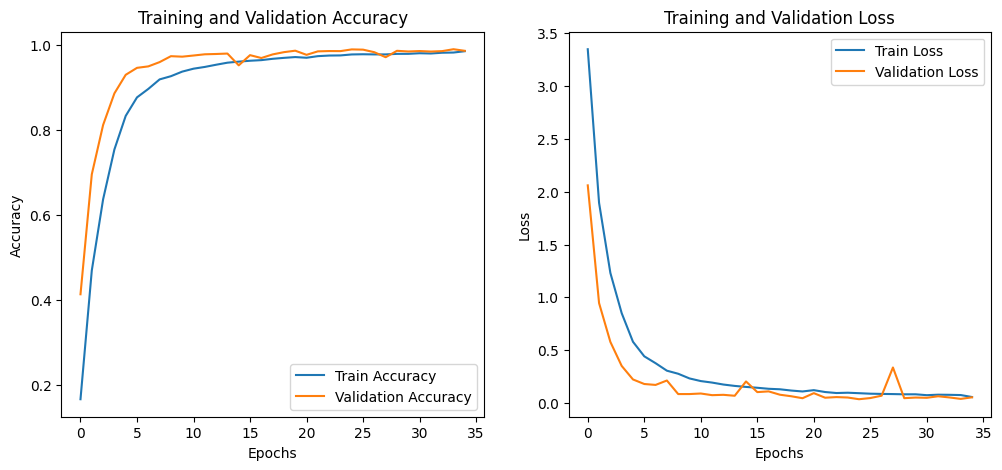

In [15]:
def plot_accuracy_loss(history):
    plt.figure(figsize=(12, 5))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')

    plt.show()

  # Generate accuracy & loss graph
plot_accuracy_loss(history)

395/395 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step


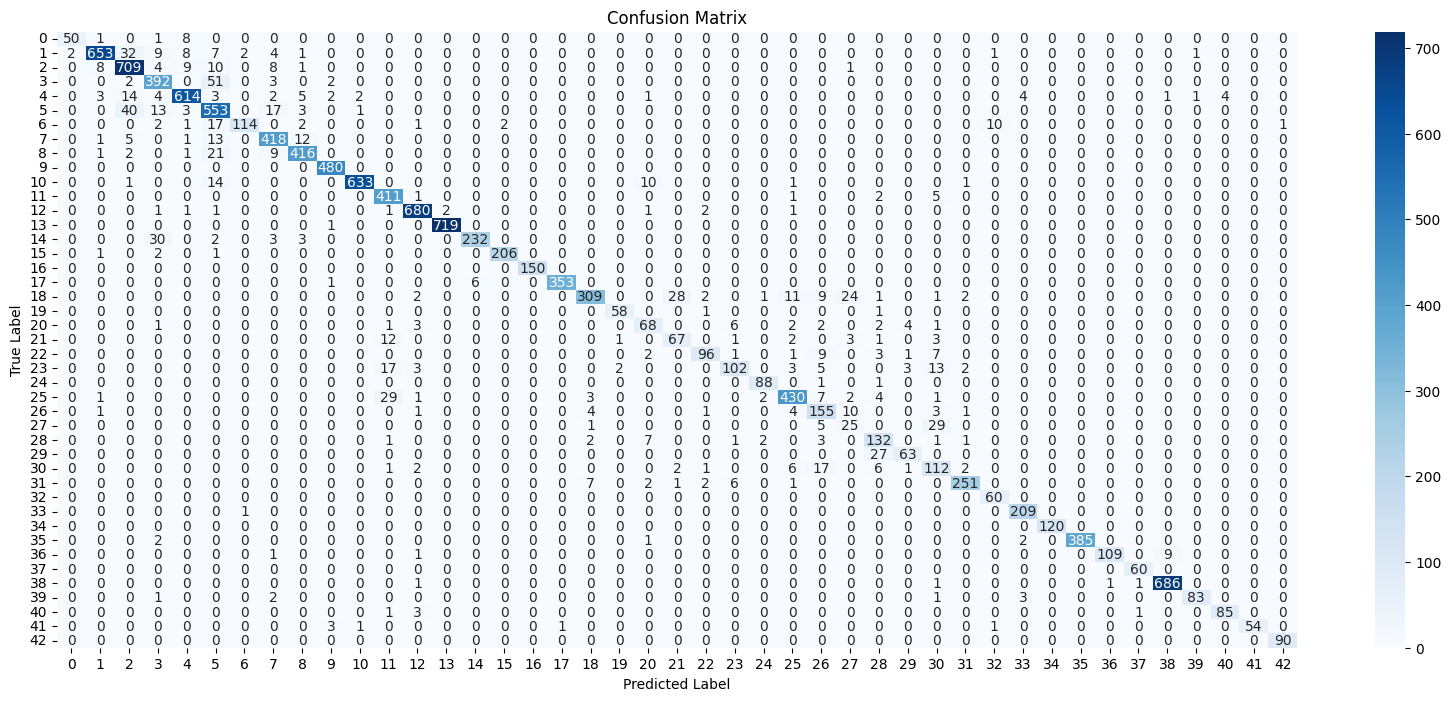

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.83      0.89        60
           1       0.97      0.91      0.94       720
           2       0.88      0.95      0.91       750
           3       0.85      0.87      0.86       450
           4       0.95      0.93      0.94       660
           5       0.80      0.88      0.84       630
           6       0.97      0.76      0.85       150
           7       0.90      0.93      0.91       450
           8       0.94      0.92      0.93       450
           9       0.98      1.00      0.99       480
          10       0.99      0.96      0.98       660
          11       0.87      0.98      0.92       420
          12       0.97      0.99      0.98       690
          13       1.00      1.00      1.00       720
          14       0.97      0.86      0.91       270
          15       0.99      0.98      0.99       210
          16       1.00      1.00      1.00       150
    

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Get model predictions
y_pred_probs = model.predict(X_test_norm)  # Predict probabilities
y_pred = np.argmax(y_pred_probs, axis=1)   # Convert to class labels

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(20, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Print Classification Report (Precision, Recall, F1-Score)
print("Classification Report:")
print(classification_report(y_test, y_pred))


395/395 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


ValueError: num must be an integer with 1 <= num <= 10, not 11

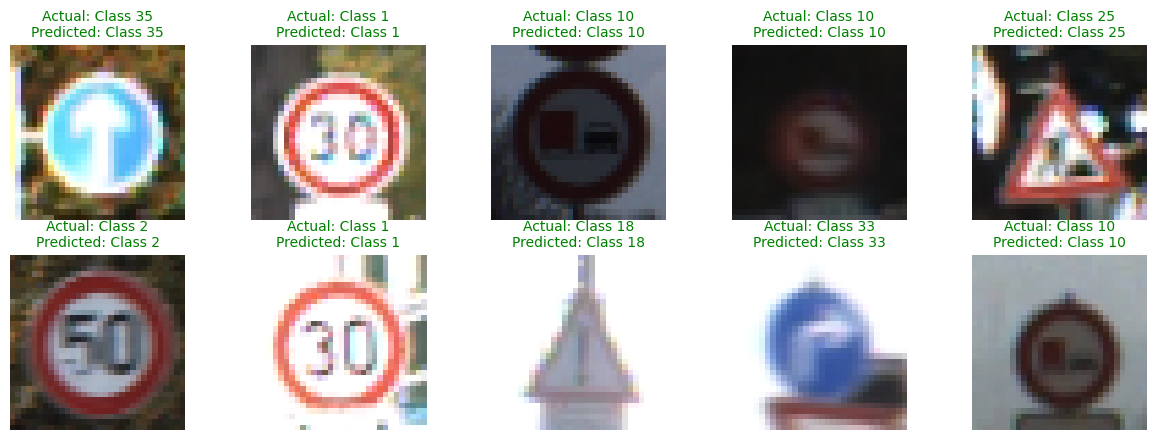

In [17]:
import numpy as np
import matplotlib.pyplot as plt

# Class labels (Modify this if your dataset has specific class names)
class_labels = {i: f"Class {i}" for i in range(len(np.unique(y_test)))}

# Get model predictions
y_pred_probs = model.predict(X_test_norm)  # Predict probabilities
y_pred = np.argmax(y_pred_probs, axis=1)   # Convert to class labels

# Number of images to display
num_images = 20
indices = np.random.choice(len(X_test_norm), num_images, replace=False)  # Randomly select images

# Plot images with actual & predicted labels
plt.figure(figsize=(15, 5))
for i, idx in enumerate(indices):
    plt.subplot(2, 5, i+1)
    plt.imshow(X_test[idx].squeeze(), cmap='gray')  # Display image
    actual_label = class_labels[y_test[idx]]
    predicted_label = class_labels[y_pred[idx]]

    # Set title with actual and predicted labels
    plt.title(f"Actual: {actual_label}\nPredicted: {predicted_label}", fontsize=10, color='green' if y_test[idx] == y_pred[idx] else 'red')
    plt.axis('off')

plt.tight_layout()
plt.show()
